In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
players <- read_csv("https://raw.githubusercontent.com/Vivian-Bi/ds_project_individual/refs/heads/main/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
player_data<- players |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as.numeric(subscribe)) |> #1 = TRUE, 0 = FALSE
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != 'NA')
player_data

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
1,30.3,9
1,3.8,17
0,0.0,17
⋮,⋮,⋮
0,0.3,22
0,0.0,17
0,2.3,17


In [4]:
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)  
player_training <- training(player_split)
player_testing <- testing(player_split)

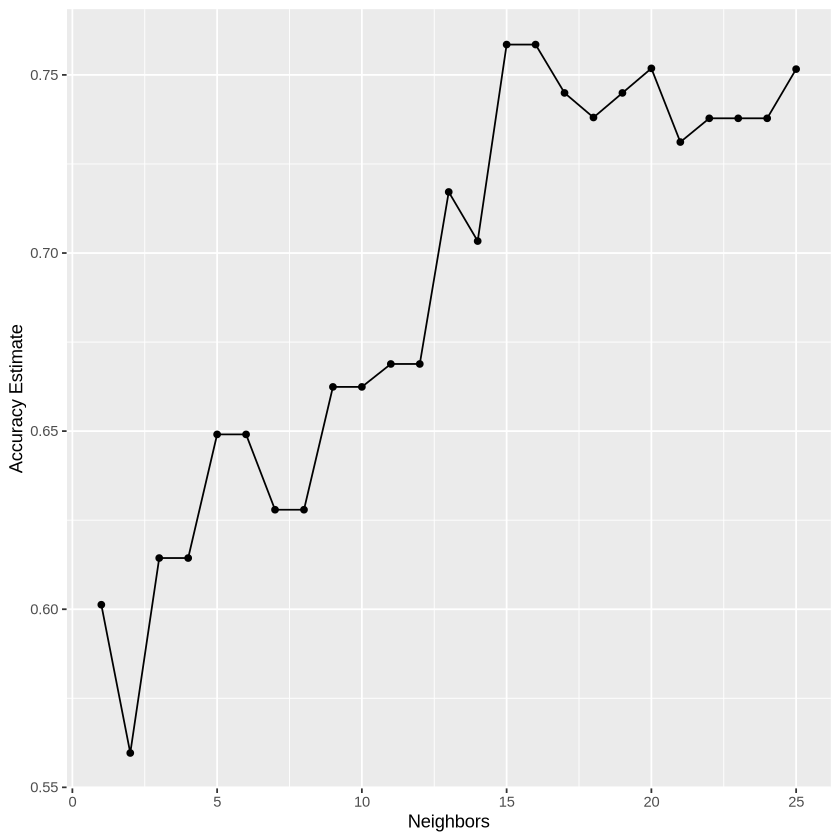

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training)

player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

player_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = player_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- player_results |>
     filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
    
cross_val_plot

In [9]:
knn_spec_cv <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
      set_engine("kknn") |>
      set_mode("classification")

player_fit <- knn_spec_cv |> 
       fit(subscribe ~ played_hours + Age, data = player_training)

player_predictions <- predict(player_fit, player_testing) |>
      bind_cols(player_testing)
player_predictions

player_metrics <- player_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)  
player_metrics

player_conf_mat <- player_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)
player_conf_mat

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
1,0,0,17
1,1,0,17
1,1,0,17
⋮,⋮,⋮,⋮
0,1,0.1,44
1,1,0.0,17
1,0,0.3,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776
kap,binary,-0.0761347


          Truth
Prediction  0  1
         0  0  2
         1 13 34